# Memory with recurrent PCN

This is a demo for recurrent predictive coding nets (aka covariance-learning pcns) in associative memory task. The implementation of recurrent pcns is based on a new subclass of `PCLayer` called `RecPCLayer`.

Recurrent pcns work in a similar way to Hopfield Networks (and we can actually show a close relationship between their energy functions!)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Bogacz-Group/PredictiveCoding/blob/main/3_memory_rpc.ipynb)

In [1]:
# import pc library of the code is being run on google colab
try:
  import google.colab
  ! git clone https://github.com/Bogacz-Group/PredictiveCoding.git
  ! cp -r PredictiveCoding/predictive_coding predictive_coding 
except ImportError:
  pass

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
import random
import numpy as np
import os
import matplotlib.pyplot as plt

import predictive_coding as pc

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


## Load data

Get train and test dataloaders for memories

In [3]:
train_size = 5
test_size = 5
batch_size = 5

transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
train = datasets.MNIST('./data', train=True, transform=transform, download=True)
test = datasets.MNIST('./data', train=False, transform=transform, download=True)

if train_size != len(train):
    train = torch.utils.data.Subset(train, random.sample(range(len(train)), train_size))
if test_size != len(test):
    test = torch.utils.data.Subset(test, random.sample(range(len(test)), test_size))

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

Utility functions to mask and blur images

In [4]:
def mask_input(input):
    """mask a given input on bottom half of image and return mask and corrupted input
    """
    h, w = input.shape[1], input.shape[2]
    device = input.device
    # take top half of image
    mask_top = torch.ones_like(input[:, :input.shape[1]//2, :]).to(device)
    input_top = mask_top * input[:, :input.shape[1]//2, :].clone().detach().requires_grad_(False)
    # mask bottom half of image
    mask_bottom = torch.zeros_like(input[:, input.shape[1]//2:, :]).to(device)
    input_bottom = mask_bottom * input[:, input.shape[1]//2:, :].clone().detach().requires_grad_(False)
    # concatenate masks
    mask = torch.cat((mask_top, mask_bottom), dim=1)
    corrupted_input = torch.cat((input_top, input_bottom), dim=1)
    return mask, corrupted_input

def blur_input(input):
    h, w = input.shape[1], input.shape[2]
    device = input.device
    # add small gaussian noise to input
    mask = (0.1 * torch.randn(input.shape)).to(device)
    return mask, mask + input
    

In [5]:
class Options:
    pass
options = Options()

options.learning_rate = 1e-3
options.epochs = 200
options.train_size = 5
options.batch_size = 5
options.test_size = 5

## Define model

In [6]:
# a single layer recurrent pcn
# note that we don't need a pc layer for training
model = pc.RecPCLayer(784, 
    is_zero_diagonal_Wr=True,
).to(device)
model.train()

RecPCLayer(
  (Wr): RecLayer()
)

## Define trainer

In [7]:
learning_rate = 1e-3
pc_trainer = pc.PCTrainer(
    model, 
    update_p_at='last',
    optimizer_p_fn=optim.Adam,
    optimizer_p_kwargs={"lr": learning_rate},
    plot_progress_at=[],
)

## train model

In [8]:
epochs = 200

# get data
X, _ = next(iter(train_loader)) # get a batch of data
X = X.to(device)
losses = []
for i in range(epochs):
    # for single-layer rPCN we don't need a loss function
    # the model is trained on the internal energy of this PCLayer
    results = pc_trainer.train_on_batch(
        inputs=X,
        loss_fn=None, 
        is_log_progress=False,
        is_return_results_every_t=False,
    )
    loss = results['energy'][0]
    if i % 10 == 0:
        print(f'epoch {i} loss: {loss}')
    losses.append(results['energy'][0])

epoch 0 loss: 264.0986328125
epoch 10 loss: 41.24494171142578
epoch 20 loss: 6.8506317138671875
epoch 30 loss: 3.545499801635742
epoch 40 loss: 1.519050121307373
epoch 50 loss: 0.550276517868042
epoch 60 loss: 0.17734476923942566
epoch 70 loss: 0.06603377312421799
epoch 80 loss: 0.024373052641749382
epoch 90 loss: 0.008850052021443844
epoch 100 loss: 0.0029183770529925823
epoch 110 loss: 0.001147751696407795
epoch 120 loss: 0.0003843042941298336
epoch 130 loss: 0.00013331949594430625
epoch 140 loss: 4.744563557324e-05
epoch 150 loss: 1.817964766814839e-05
epoch 160 loss: 6.3601869442209136e-06
epoch 170 loss: 2.115573806804605e-06
epoch 180 loss: 7.352133479798795e-07
epoch 190 loss: 2.9637527632075944e-07


## Visualise results

Loss function during training

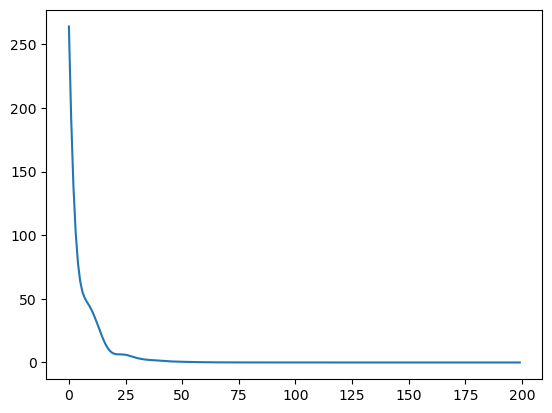

In [9]:
plt.figure()
plt.plot(losses)
plt.show()

Use model to recover memories from masked input

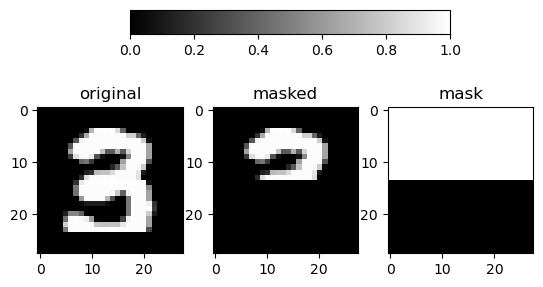

In [10]:
# test data: masked input
X_test = X[:4].reshape(-1, 28, 28)
mask, X_c = mask_input(X_test)
X_c2 = X_c.clone()

# show exmaples of original and masked data
fig, ax = plt.subplots(1, 3)
ax[0].imshow(X_test[0].cpu().numpy(), cmap='gray')
ax[0].set_title('original')
ax[1].imshow(X_c[0].cpu().detach().numpy(), cmap='gray')
ax[1].set_title('masked')
im = ax[2].imshow(mask[0].cpu().numpy(), cmap='gray')
ax[2].set_title('mask')
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')
plt.show()

In [11]:
# test model; set eval to initialize value nodes by sampling
# note that model.eval doesn't prohibit training, it only affects dropout and batchnorm
# also note that the default sample fn of a (rec)pclayer is to set it to the input to the layer, which is the corrupted input here
# this is what we (should) use here
model.set_mode('inference')

pc_tester = pc.PCTrainer(
    model, 
    T=1000,
    update_x_at='all',
    optimizer_x_fn=optim.SGD,
    optimizer_x_kwargs={"lr": 0.01},
    update_p_at='never', # do not update parameters during inference
    plot_progress_at=[],
)

results = pc_tester.train_on_batch(
    inputs=X_c.reshape(-1, 784),
    is_log_progress=True,
    is_return_results_every_t=True,
)

c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_log_progress enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\olivi\OneDrive - Nexus365\Projects\PredictiveCoding\predictive_coding\utils.py:9: RuntimeWarning: In PCTrainer.train_on_batch, you have is_return_results_every_t enabled, this will slow down training. Set to False to disable it. 
  warnings.warn(
| e: 5.298e-03 | o: 5.298e-03 |: 100%|██████████| 1000/1000 [00:03<00:00, 332.37it/s]


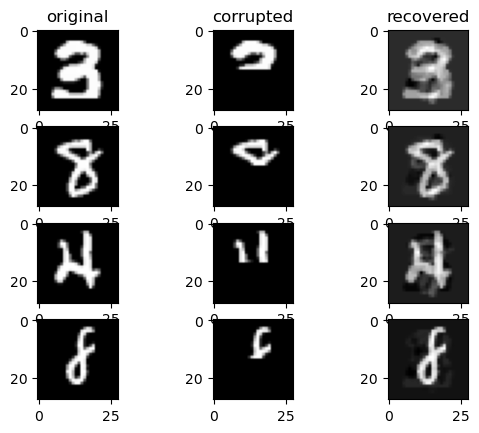

In [12]:
pred = model.get_x().reshape(-1, 28, 28)

# show exmaples of original and predicted data
fig, ax = plt.subplots(pred.shape[0], 3)
for i in range(pred.shape[0]):
    ax[i, 0].imshow(X_test[i].cpu().numpy(), cmap='gray')
    ax[i, 1].imshow(X_c2[i].detach().cpu().numpy(), cmap='gray')
    ax[i, 2].imshow(pred[i].detach().cpu().numpy(), cmap='gray')
ax[0, 0].set_title('original')
ax[0, 1].set_title('corrupted')
ax[0, 2].set_title('recovered')
plt.show()
